In [9]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Classifiers from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from scipy.stats import pointbiserialr
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,collect_list, to_timestamp, expr, regexp_replace,split, to_timestamp, from_unixtime,date_format,when,concat,lit,hour,minute,to_date
from pyspark.sql.types import StructType, StringType, StructField


In [10]:
# Loading the combined flight and weather data
filepath = r"C:\Users\httyd\Desktop\capstone\Data\part-00000-930aba24-9012-4e07-8585-47f458697fad-c000.csv"
df = pd.read_csv(filepath)

# Understanding the column data
print(df.info())
print(f"\nShape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636419 entries, 0 to 636418
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Year                 636419 non-null  int64  
 1   Quarter              636419 non-null  int64  
 2   Month                636419 non-null  int64  
 3   DayofMonth           636419 non-null  int64  
 4   FlightDate           636419 non-null  object 
 5   OriginAirportID      636419 non-null  int64  
 6   Origin               636419 non-null  object 
 7   DestAirportID        636419 non-null  int64  
 8   Dest                 636419 non-null  object 
 9   CRSDepTime           636419 non-null  int64  
 10  DepTime              636419 non-null  int64  
 11  DepDelayMinutes      636419 non-null  float64
 12  DepDel15             636419 non-null  float64
 13  CRSArrTime           636419 non-null  object 
 14  ArrTime              636419 non-null  int64  
 15  ArrDelayMinutes  

In [11]:
# Dropping columns with redundant or duplicate data
df.drop(columns=["FlightDate",
                 "OriginAirportID",
                 "DestAirportID",
                 "CRSArrTime",
                 "ArrTime",
                 "ArrDelayMinutes",
                 "Weatherrounded_hour",
                 "Date",
                 "Time",
                 "AreaCode"],
        inplace=True)
print(f"\nShape: {df.shape}", end="\n\n")
print(df.info())
# df.to_csv("./Data/flight_and_weather_without_redundant_info.csv")


Shape: (636419, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636419 entries, 0 to 636418
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Year             636419 non-null  int64  
 1   Quarter          636419 non-null  int64  
 2   Month            636419 non-null  int64  
 3   DayofMonth       636419 non-null  int64  
 4   Origin           636419 non-null  object 
 5   Dest             636419 non-null  object 
 6   CRSDepTime       636419 non-null  int64  
 7   DepTime          636419 non-null  int64  
 8   DepDelayMinutes  636419 non-null  float64
 9   DepDel15         636419 non-null  float64
 10  ArrDel15         636419 non-null  float64
 11  rounded_hour     636419 non-null  object 
 12  Temperature(°F)  636419 non-null  object 
 13  DewPoint(°F)     636419 non-null  object 
 14  Humidity(%)      636419 non-null  object 
 15  WindSpeed(mph)   636419 non-null  object 
 16  WindGust(mph)   

In [19]:
# Convert columns to string type
df['Temperature(°F)'] = df['Temperature(°F)'].astype(str)
df['DewPoint(°F)'] = df['DewPoint(°F)'].astype(str)
df['Humidity(%)'] = df['Humidity(%)'].astype(str)
df['WindSpeed(mph)'] = df['WindSpeed(mph)'].astype(str)
df['WindGust(mph)'] = df['WindGust(mph)'].astype(str)
df['Pressure(in)'] = df['Pressure(in)'].astype(str)
df['Precip(in)'] = df['Precip(in)'].astype(str)
df['rounded_hour'] = df['rounded_hour'].astype(str)

# Remove non-numeric characters and convert to float
df['Temperature(°F)'] = df['Temperature(°F)'].str.replace('[^0-9.-]', '').astype(float)
df['DewPoint(°F)'] = df['DewPoint(°F)'].str.replace('[^0-9.-]', '').astype(float)
df['Humidity(%)'] = df['Humidity(%)'].str.replace('[^0-9.-]', '').astype(float)
df['WindSpeed(mph)'] = df['WindSpeed(mph)'].str.replace('[^0-9.-]', '').astype(float)
df['WindGust(mph)'] = df['WindGust(mph)'].str.replace('[^0-9.-]', '').astype(float)
df['Pressure(in)'] = df['Pressure(in)'].str.replace('[^0-9.-]', '').astype(float)
df['Precip(in)'] = df['Precip(in)'].str.replace('[^0-9.-]', '').astype(float)

df['rounded_hour'] = pd.to_datetime(df['rounded_hour'], format='%H:%M:%S').dt.hour.astype(float)




# Convert to int64
df['Temperature(°F)'] = df['Temperature(°F)'].astype('int64')
df['DewPoint(°F)'] = df['DewPoint(°F)'].astype('int64')
df['Humidity(%)'] = df['Humidity(%)'].astype('int64')
df['WindSpeed(mph)'] = df['WindSpeed(mph)'].astype('int64')
df['WindGust(mph)'] = df['WindGust(mph)'].astype('int64')
df['Pressure(in)'] = df['Pressure(in)'].astype('int64')
df['Precip(in)'] = df['Precip(in)'].astype('int64')
df['rounded_hour'] = df['rounded_hour'].astype('int64')


ValueError: time data "0" doesn't match format "%H:%M:%S", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

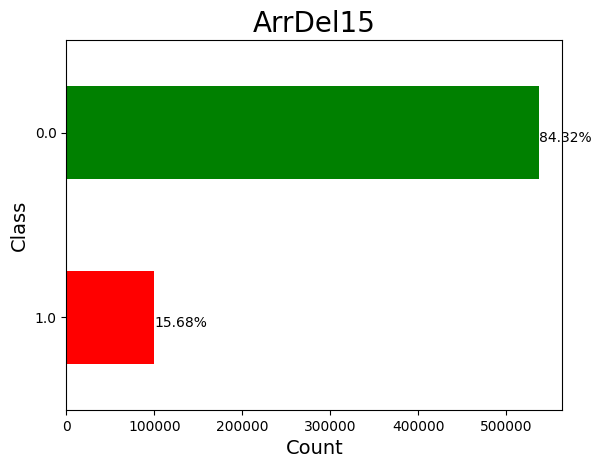

ArrDel15
0.0    536625
1.0     99794
Name: count, dtype: int64


In [ ]:
# Plotting the percentage of observations that fall under each class
ax = df["ArrDel15"].value_counts().sort_values().plot(kind="barh", color=["r", "g"])
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("ArrDel15", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(df["ArrDel15"].value_counts())
fig = ax.get_figure()


In [ ]:
# encode categorical data into numeric values
labelEncoder = LabelEncoder()
df["Origin"] = labelEncoder.fit_transform(df["Origin"])
df["Dest"] = labelEncoder.fit_transform(df["Dest"])
df["Condition"] = labelEncoder.fit_transform(df["Condition"])

# get continuous and dichotomous data
categorical = ["Year", "Quarter", "Month", "DayofMonth", "Origin", "Dest", "CRSDepTime","Condition", "DepTime","WindDir" ,"DepDel15", "Precip(in)", "rounded_hour", "ArrDel15"]
numeric = ["DepDelayMinutes", "WindSpeed(mph)", "Precip(in)", "Pressure(in)", "DewPoint(°F)", "WindGust(mph)", "Temperature(°F)", "Humidity(%)"]
target = df["ArrDel15"]

# pbc of first question
pbc = list()
for col in numeric:
    ans = pointbiserialr(df[col], target)
    pbc.append([col, ans[0], ans[1]])
    
pbc_corr = pd.DataFrame(pbc, columns=["Feature", "CorrCoeff", "pValue"]).sort_values(by="CorrCoeff", ascending=False).reset_index(drop=True)
pbc_corr

,Feature,CorrCoeff,pValue
0,DepDelayMinutes,0.476770,0.000000e+00
1,Humidity(%),0.077131,0.000000e+00
2,DewPoint(°F),0.063706,0.000000e+00
3,WindSpeed(mph),0.037590,1.031768e-197
4,WindGust(mph),0.036850,4.433039e-190
5,Precip(in),0.022996,3.460967e-75
6,Temperature(°F),0.021359,4.070378e-65
7,Pressure(in),-0.011128,6.828023e-19


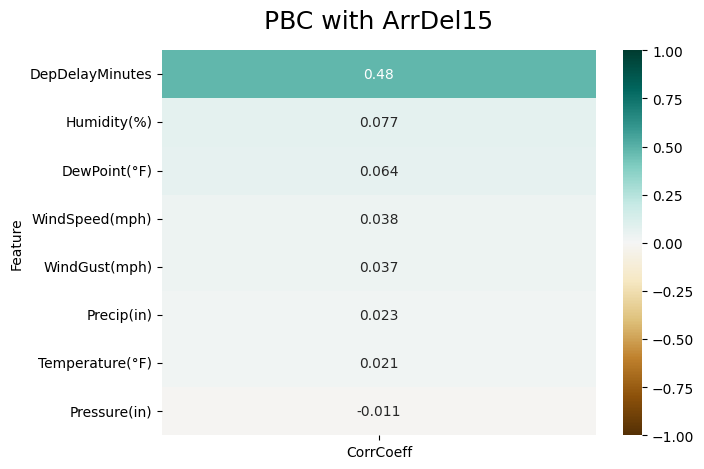

In [ ]:
plt.figure(figsize=(7, 5))
pbc_corr = pbc_corr.set_index("Feature")
heatmap = sns.heatmap(pbc_corr[["CorrCoeff"]].sort_values(by="CorrCoeff", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("PBC with ArrDel15", fontdict={"fontsize":18}, pad=16);

del pbc_corr

In [ ]:
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(df[categorical].corr(method="spearman")[["ArrDel15"]].sort_values(by="ArrDel15", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Spearman Correlations with ArrDel15", fontdict={"fontsize":18}, pad=16)

del heatmap

ValueError: could not convert string to float: '00:00:00'

<Figure size 700x500 with 0 Axes>